In [1]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)
        self.x = df.iloc[:, 0].values
        self.y = df.iloc[:, 1].values
        self.length = len(df)

    def __getitem__(self, index):
        x = torch.FloatTensor([self.x[index] ** 2, self.x[index]])
        y = torch.FloatTensor([self.y[index]])
        return x, y

    def __len__(self):
        return self.length

In [3]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(2, 1)

    def forward(self, x):
        x = self.layer(x)
        return x

In [4]:
dataset = CustomDataset("../datasets/non_linear.csv")
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)

Training Data Size : 53
Validation Data Size : 6
Testing Data Size : 8


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CustomModel().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [6]:
for epoch in range(10000):
    cost = 0.0

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss

    cost = cost / len(train_dataloader)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch : {epoch+1:4d}, Model : {list(model.parameters())}, Cost : {cost:.3f}")

Epoch : 1000, Model : [Parameter containing:
tensor([[ 2.8762, -1.3581]], requires_grad=True), Parameter containing:
tensor([0.1419], requires_grad=True)], Cost : 17.010
Epoch : 2000, Model : [Parameter containing:
tensor([[ 2.8792, -1.3437]], requires_grad=True), Parameter containing:
tensor([0.4176], requires_grad=True)], Cost : 15.347
Epoch : 3000, Model : [Parameter containing:
tensor([[ 2.8701, -1.3467]], requires_grad=True), Parameter containing:
tensor([0.6329], requires_grad=True)], Cost : 15.751
Epoch : 4000, Model : [Parameter containing:
tensor([[ 2.8612, -1.3504]], requires_grad=True), Parameter containing:
tensor([0.8000], requires_grad=True)], Cost : 15.381
Epoch : 5000, Model : [Parameter containing:
tensor([[ 2.8539, -1.3502]], requires_grad=True), Parameter containing:
tensor([0.9315], requires_grad=True)], Cost : 15.501
Epoch : 6000, Model : [Parameter containing:
tensor([[ 2.8633, -1.3465]], requires_grad=True), Parameter containing:
tensor([1.0341], requires_grad=Tr

In [7]:
with torch.no_grad():
    model.eval()
    for x, y in validation_dataloader:
        x = x.to(device)
        y = y.to(device)
        
        outputs = model(x)
        print(f"X : {x}")
        print(f"Y : {y}")
        print(f"Outputs : {outputs}")
        print("--------------------")

X : tensor([[16.0000,  4.0000],
        [ 9.0000,  3.0000],
        [ 4.0000,  2.0000],
        [ 6.2500, -2.5000]])
Y : tensor([[42.1000],
        [23.9000],
        [10.2000],
        [23.1000]])
Outputs : tensor([[41.7628],
        [23.0353],
        [10.0431],
        [22.5525]])
--------------------


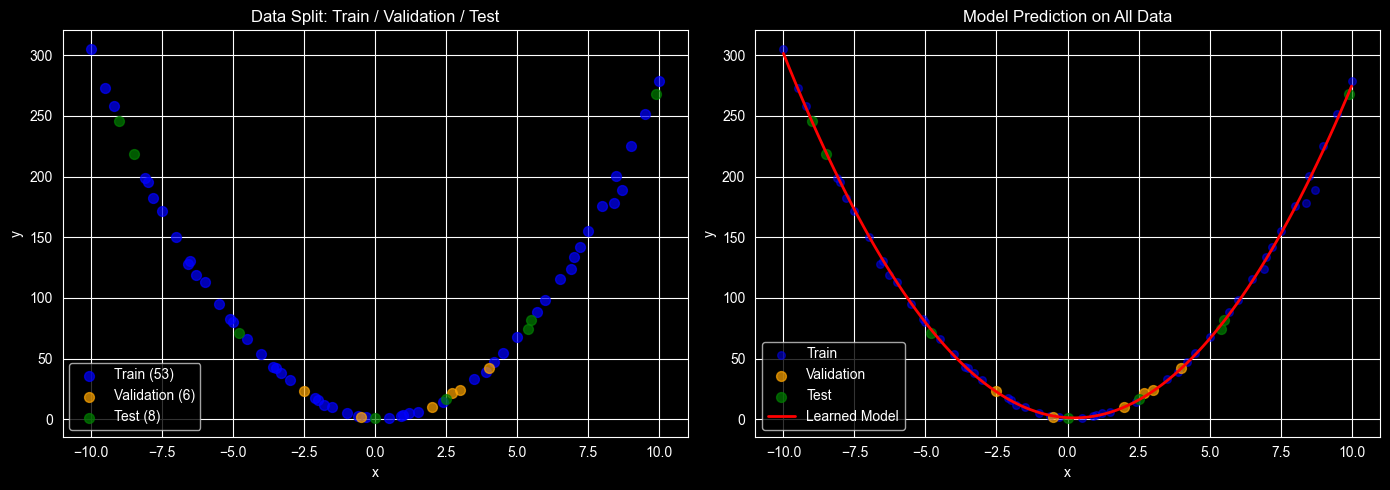

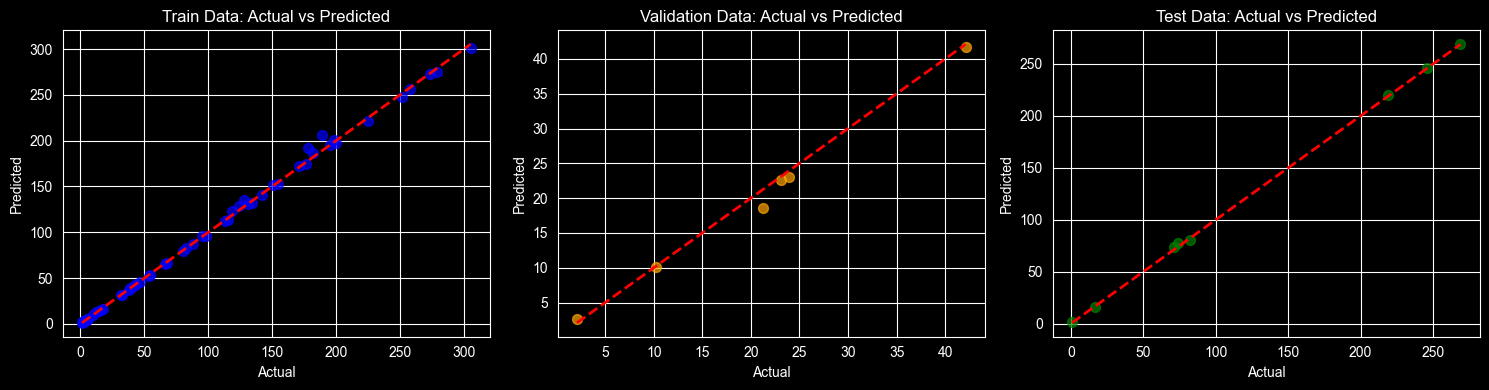


Summary: Data Split
  Train:       53 samples (79.1%)
  Validation:   6 samples (9.0%)
  Test:         8 samples (11.9%)
  Total:       67 samples


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Collect all data points with their dataset labels
train_x_list, train_y_list = [], []
valid_x_list, valid_y_list = [], []
test_x_list, test_y_list = [], []

for x, y in train_dataset:
    train_x_list.append(x[1].item())  # x value (not x²)
    train_y_list.append(y.item())

for x, y in validation_dataset:
    valid_x_list.append(x[1].item())
    valid_y_list.append(y.item())

for x, y in test_dataset:
    test_x_list.append(x[1].item())
    test_y_list.append(y.item())

# Visualization 1: Data Split
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(train_x_list, train_y_list, alpha=0.7, label=f'Train ({len(train_x_list)})', color='blue', s=50)
plt.scatter(valid_x_list, valid_y_list, alpha=0.7, label=f'Validation ({len(valid_x_list)})', color='orange', s=50)
plt.scatter(test_x_list, test_y_list, alpha=0.7, label=f'Test ({len(test_x_list)})', color='green', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data Split: Train / Validation / Test')
plt.legend()
plt.grid(True)

# Visualization 2: Model Prediction Curve
plt.subplot(1, 2, 2)

# Generate smooth curve
all_x = train_x_list + valid_x_list + test_x_list
x_range = np.linspace(min(all_x), max(all_x), 100)
x_input = torch.FloatTensor([[x**2, x] for x in x_range]).to(device)

with torch.no_grad():
    model.eval()
    y_pred = model(x_input).cpu().numpy()

# Plot all data and prediction curve
plt.scatter(train_x_list, train_y_list, alpha=0.5, label='Train', color='blue', s=30)
plt.scatter(valid_x_list, valid_y_list, alpha=0.7, label='Validation', color='orange', s=50)
plt.scatter(test_x_list, test_y_list, alpha=0.7, label='Test', color='green', s=50)
plt.plot(x_range, y_pred, 'r-', linewidth=2, label='Learned Model')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Model Prediction on All Data')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualization 3: Actual vs Predicted for each dataset
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

datasets = [
    (train_dataset, 'Train', 'blue'),
    (validation_dataset, 'Validation', 'orange'),
    (test_dataset, 'Test', 'green')
]

for ax, (ds, name, color) in zip(axes, datasets):
    actual, predicted = [], []
    for x, y in ds:
        x = x.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(x).cpu().item()
        actual.append(y.item())
        predicted.append(pred)
    
    ax.scatter(actual, predicted, alpha=0.7, color=color, s=50)
    
    # Perfect prediction line
    min_val = min(min(actual), min(predicted))
    max_val = max(max(actual), max(predicted))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{name} Data: Actual vs Predicted')
    ax.grid(True)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "=" * 60)
print("Summary: Data Split")
print("=" * 60)
print(f"  Train:      {len(train_dataset):3d} samples ({len(train_dataset)/len(dataset)*100:.1f}%)")
print(f"  Validation: {len(validation_dataset):3d} samples ({len(validation_dataset)/len(dataset)*100:.1f}%)")
print(f"  Test:       {len(test_dataset):3d} samples ({len(test_dataset)/len(dataset)*100:.1f}%)")
print(f"  Total:      {len(dataset):3d} samples")
print("=" * 60)